In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/ryangeygan/Graphyte/Projects/project_alpha/data/elemental_analysis_data.csv')

df = df[['biomass_type', 'carbon_content', 'moisture_content_at_facility']].dropna()

df['carbon_content_moisture_corrected'] = (df.carbon_content) / (1 - df.moisture_content_at_facility)

df.groupby(['biomass_type'])['carbon_content'].count()

biomass_type
H         136
R          89
R50S50     60
S         109
Name: carbon_content, dtype: int64

### Feedstock Carbon Distribution

In [3]:
df.carbon_content.mean()

0.45011015228426404

In [4]:
df.carbon_content_moisture_corrected.std()

0.05056848961212158

## 95%CI for 3 measurements we're taking today

In [5]:
1.96 * (0.051 / np.sqrt(3))

0.05771193290819499

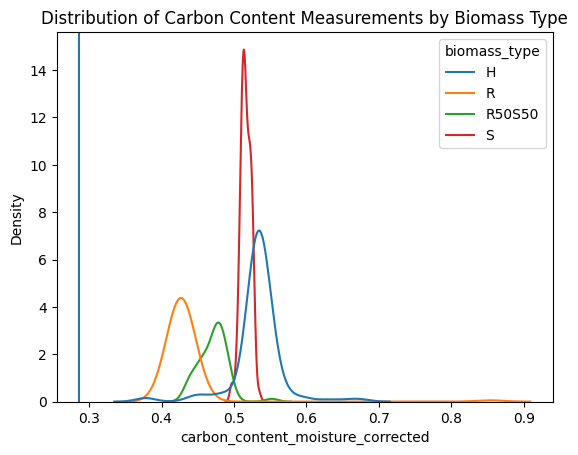

In [8]:
fig, ax = plt.subplots()

sns.kdeplot(data=df, x='carbon_content_moisture_corrected', hue='biomass_type', bw_adjust=1)

plt.title('Distribution of Carbon Content Measurements by Biomass Type')

plt.axvline(x=0.2867)

In [7]:
(0.2555) / (1 - 0.109)

0.2867564534231201

### Calculate 95% CI Curves for EA analysis

In [9]:
# Estimate standard deviation
## Leave off the "mix" type since there are only two measurements

std_biomass = df.groupby(['biomass_type'])['carbon_content_moisture_corrected'].std().reset_index().rename(columns={'carbon_content_moisture_corrected':'std_est'})

std_biomass

,biomass_type,std_est
0,H,0.034167
1,R,0.045843
2,R50S50,0.019649
3,S,0.006948


In [142]:
# Assume a per measurement uncertainty of 0.0005% or 0.000005

out_df = []

for i, row in std_biomass.iterrows():
    std = row['std_est']
    biomass_type = row['biomass_type']

    for n in range(1, 556):
        ci_1 = 2 * (2.045 * (np.sqrt(np.power(std / np.sqrt(n), 2) + np.power(0.000005, 2))))
        ci_2 = 2 * (2.045 * (np.sqrt(np.power(std / np.sqrt(n), 2) + np.power(0.015, 2))))
        out_df.append((biomass_type, n, ci_1, ci_2))

plt_df = pd.DataFrame(out_df, columns=['biomass_type', 'sample_size', 'ci_ea', 'ci_spec'])

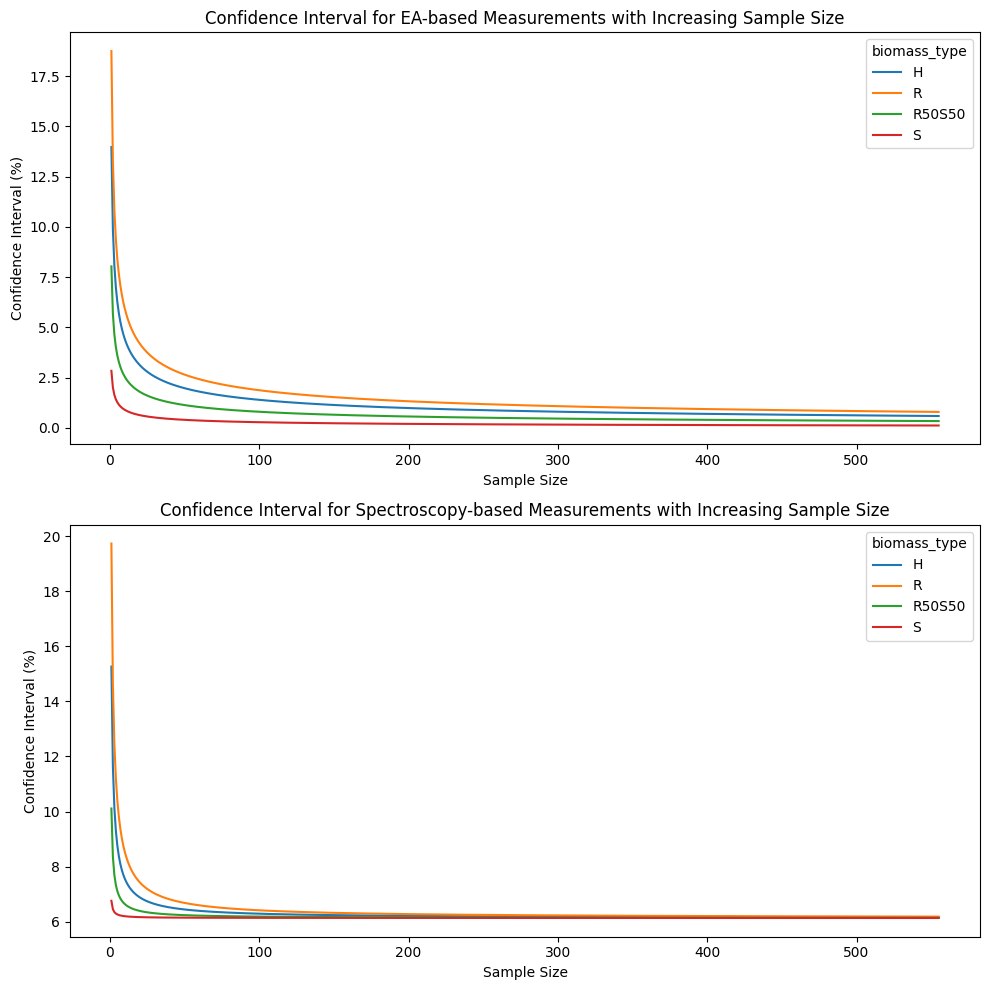

In [143]:
data = plt_df[plt_df.biomass_type != 'Mix']

# Convert CIs to percentages
data['ci_ea (%)'] = data['ci_ea'] * 100
data['ci_spec (%)'] = data['ci_spec'] * 100

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot for ci_ea
sns.lineplot(data=data, x='sample_size', y='ci_ea (%)', hue='biomass_type', ax=axes[0])
#axes[0].vlines(x=3, ymin=0, ymax=data['ci_ea (%)'].max(), linestyles='dotted', color='red')
axes[0].set_title('Confidence Interval for EA-based Measurements with Increasing Sample Size')
axes[0].set_xlabel('Sample Size')
axes[0].set_ylabel('Confidence Interval (%)')
#axes[0].text(x=4, y=0.8 * data['ci_ea (%)'].max(), s='<-- current sample size')

# Plot for ci_spec
sns.lineplot(data=data, x='sample_size', y='ci_spec (%)', hue='biomass_type', ax=axes[1])
#axes[1].vlines(x=3, ymin=0, ymax=data['ci_spec (%)'].max(), linestyles='dotted', color='red')
axes[1].set_title('Confidence Interval for Spectroscopy-based Measurements with Increasing Sample Size')
axes[1].set_xlabel('Sample Size')
axes[1].set_ylabel('Confidence Interval (%)')
#axes[1].text(x=4, y=0.8 * data['ci_spec (%)'].max(), s='<-- current sample size')

plt.tight_layout()
plt.show()

### If we Are Agnostic to Biomass type

In [133]:
std_pop = df.carbon_content_moisture_corrected.std()

In [177]:
df.carbon_content.std()

0.05121479935282659

In [178]:
std_pop

0.05056848961212158

In [175]:
out_df2 = []

for n in range(1, 556):
    ci_1 = 2 * (2.045 * (np.sqrt(np.power(std_pop / np.sqrt(n), 2) + np.power(0.000005, 2))))
    ci_2 = 2 * (2.045 * (np.sqrt(np.power(std_pop / np.sqrt(n), 2) + np.power(0.011, 2))))
    out_df2.append((biomass_type, n, ci_1, ci_2))

plt_df2 = pd.DataFrame(out_df2, columns=['biomass_type', 'sample_size', 'ci_ea_pop', 'ci_spec_pop'])

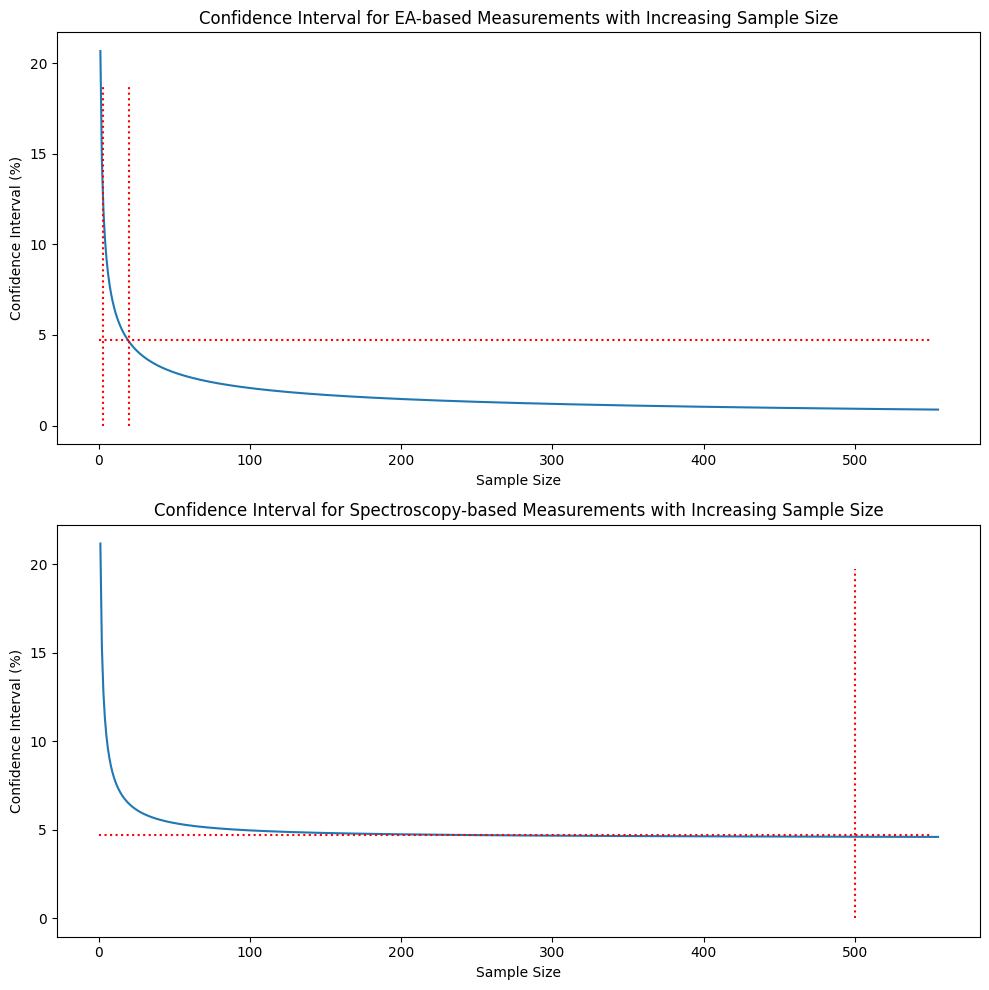

In [180]:
data2 = plt_df2

# Convert CIs to percentages
data2['ci_ea (%)'] = data2['ci_ea_pop'] * 100
data2['ci_spec (%)'] = data2['ci_spec_pop'] * 100

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot for ci_ea
sns.lineplot(data=data2, x='sample_size', y='ci_ea (%)', ax=axes[0])
axes[0].vlines(x=3, ymin=0, ymax=data['ci_ea (%)'].max(), linestyles='dotted', color='red')
axes[0].vlines(x=20, ymin=0, ymax=data['ci_ea (%)'].max(), linestyles='dotted', color='red')
axes[0].hlines(y=4.7, xmin=0, xmax=550, linestyles='dotted', color='red')
axes[0].set_title('Confidence Interval for EA-based Measurements with Increasing Sample Size')
axes[0].set_xlabel('Sample Size')
axes[0].set_ylabel('Confidence Interval (%)')
#axes[0].text(x=4, y=0.8 * data['ci_ea (%)'].max(), s='<-- current sample size')

# Plot for ci_spec
sns.lineplot(data=data2, x='sample_size', y='ci_spec (%)', ax=axes[1])
axes[1].vlines(x=500, ymin=0, ymax=data['ci_spec (%)'].max(), linestyles='dotted', color='red')
axes[1].hlines(y=4.7, xmin=0, xmax=550, linestyles='dotted', color='red')
axes[1].set_title('Confidence Interval for Spectroscopy-based Measurements with Increasing Sample Size')
axes[1].set_xlabel('Sample Size')
axes[1].set_ylabel('Confidence Interval (%)')
#axes[1].text(x=4, y=0.8 * data['ci_spec (%)'].max(), s='<-- current sample size')

plt.tight_layout()
plt.show()

In [174]:
# # Generate x values
# x = np.linspace(0, 100_000_000, 10_000)

# # Generate y values for the linearly increasing curve with a slope of 0.5
# y = 0.5 * x

# # Calculate the upper and lower bounds (4% more and less than the center line)
# y_upper = y * 1.04
# y_lower = y * 0.96

# # Plot the linearly increasing curve
# plt.plot(x, y, label='Linear Increase (slope = 0.5)', color='blue')

# # Fill the area between y_lower and y_upper
# plt.fill_between(x, y_lower, y_upper, color='lightblue', alpha=0.5, label='±4% Threshold')

# # Add labels and title
# plt.xlabel('Processed Mass')
# plt.ylabel('Estimated Mass')
# plt.title('Growth of Error from EA-based Measurements')
# plt.legend()

# # Show the plot
# plt.show()